# Recipe 3-6. Implementing a Convolutional Neural Network (CNN)

In [1]:
#CNN

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.manual_seed(1)    # reproducible

In [4]:
# Hyper Parameters
EPOCH = 1
# train the input data n times, to save time, we just train 1 epoch
# 50 samples at a time to pass through the epoch
BATCH_SIZE = 50
# learning rate
LR = 0.001
# set to False if you have downloaded
DOWNLOAD_MNIST = True

In [6]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     
    # this is training data
    transform=torchvision.transforms.ToTensor(),    
    # torch.FloatTensor of shape (Color x Height x Width) and 
    #normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        
    # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000])


c:\users\andy\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\users\andy\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


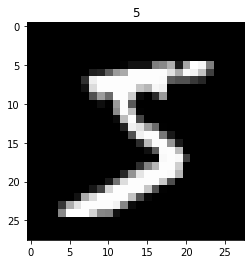

In [7]:
# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [8]:
# Data Loader for easy mini-batch return in training, the image batch shape will be 
#(50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)[:2000]/255.   
# shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]

c:\users\andy\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\users\andy\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [14]:
'''
nn.Sequential：
    A sequential container.
    Modules will be added to it in the order they are passed in the constructor.
    Alternatively, an ordered dict of modules can also be passed in.
    
nn.Conv2d：
    in_channels(int) – 输入信号的通道【通道数，和上面保持一致，也就是当前层的深度】
    out_channels(int) - 卷积产生的通道【输出的深度】
    kerner_size(int or tuple) - 卷积核的尺寸
    stride(int or tuple, optional) - 卷积步长
    padding(int or tuple, optional) - 输入的每一条边补充0的层数
    dilation(int or tuple, optional) – 卷积核元素之间的间距
    groups(int, optional) – 从输入通道到输出通道的阻塞连接数
    bias(bool, optional) - 如果bias=True，添加偏置

nn.MaxPool2d:
    kernel_size(int or tuple) - max pooling的窗口大小
    stride(int or tuple, optional) - max pooling的窗口移动的步长。默认值是kernel_size
    padding(int or tuple, optional) - 输入的每一条边补充0的层数
    dilation(int or tuple, optional) – 一个控制窗口中元素步幅的参数
    return_indices - 如果等于True，会返回输出最大值的序号，对于上采样操作会有帮助
    ceil_mode - 如果等于True，计算输出信号大小的时候，会使用向上取整，代替默认的向下取整的操作
'''

'\nnn.Sequential：\n    A sequential container.\n    Modules will be added to it in the order they are passed in the constructor.\n    Alternatively, an ordered dict of modules can also be passed in.\n    \nnn.Conv2d：\n    in_channels(int) – 输入信号的通道【通道数，和上面保持一致，也就是当前层的深度】\n    out_channels(int) - 卷积产生的通道【输出的深度】\n    kerner_size(int or tuple) - 卷积核的尺寸\n    stride(int or tuple, optional) - 卷积步长\n    padding(int or tuple, optional) - 输入的每一条边补充0的层数\n    dilation(int or tuple, optional) – 卷积核元素之间的间距\n    groups(int, optional) – 从输入通道到输出通道的阻塞连接数\n    bias(bool, optional) - 如果bias=True，添加偏置\n\nnn.MaxPool2d:\n    kernel_size(int or tuple) - max pooling的窗口大小\n    stride(int or tuple, optional) - max pooling的窗口移动的步长。默认值是kernel_size\n    padding(int or tuple, optional) - 输入的每一条边补充0的层数\n    dilation(int or tuple, optional) – 一个控制窗口中元素步幅的参数\n    return_indices - 如果等于True，会返回输出最大值的序号，对于上采样操作会有帮助\n    ceil_mode - 如果等于True，计算输出信号大小的时候，会使用向上取整，代替默认的向下取整的操作\n'

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  
                # if want same width and length of this image after con2d, 
                #padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    
            # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [11]:
cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [12]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [13]:
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization, if not there')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer');
    plt.show(); 
    #plt.pause(0.01)

Epoch:  0 | train loss: 2.2863 | test accuracy: 0.19


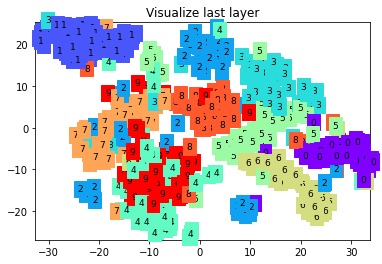

Epoch:  0 | train loss: 0.3503 | test accuracy: 0.89


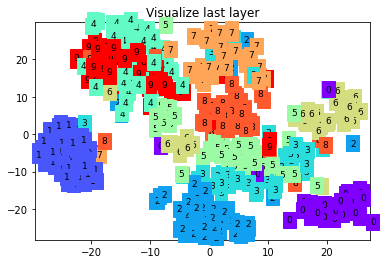

Epoch:  0 | train loss: 0.2063 | test accuracy: 0.92


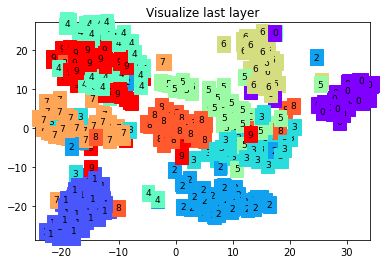

Epoch:  0 | train loss: 0.0955 | test accuracy: 0.95


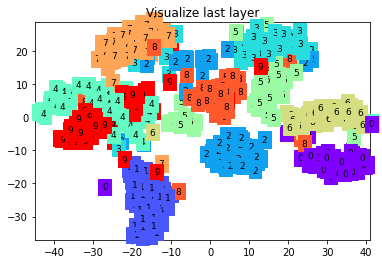

Epoch:  0 | train loss: 0.1155 | test accuracy: 0.96


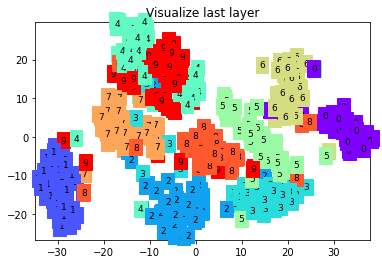

Epoch:  0 | train loss: 0.1570 | test accuracy: 0.96


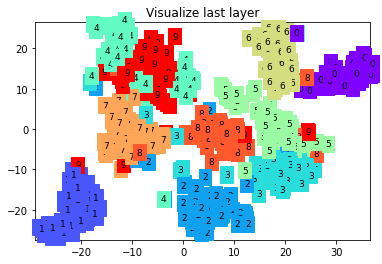

Epoch:  0 | train loss: 0.0694 | test accuracy: 0.97


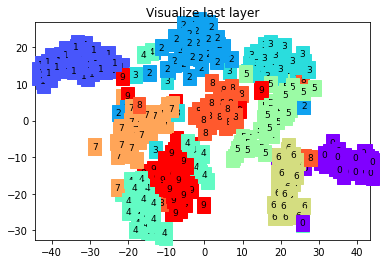

Epoch:  0 | train loss: 0.0499 | test accuracy: 0.97


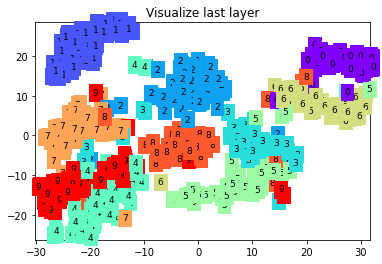

Epoch:  0 | train loss: 0.0648 | test accuracy: 0.98


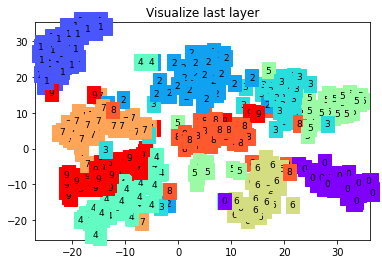

Epoch:  0 | train loss: 0.1096 | test accuracy: 0.97


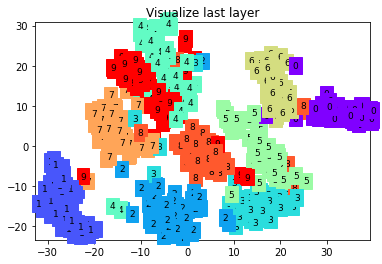

Epoch:  0 | train loss: 0.0405 | test accuracy: 0.98


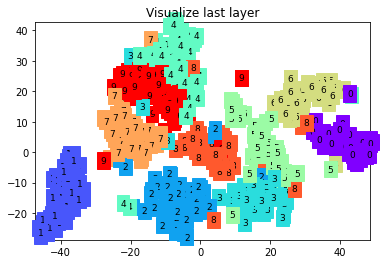

Epoch:  0 | train loss: 0.0811 | test accuracy: 0.97


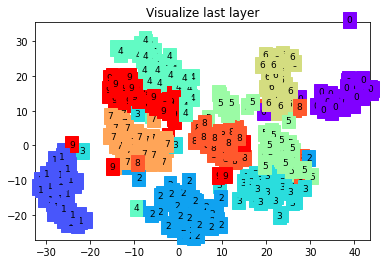

In [16]:
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   
        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]            # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data,'| test accuracy: %.2f' % accuracy)
            
            '''
            PastCode:
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0],'| test accuracy: %.2f' % accuracy)
            IndexError:
                invalid index of a 0-dim tensor.
                Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number
            ChangeTo:
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.data,'| test accuracy: %.2f' % accuracy)
            '''
            
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

In [22]:
# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [23]:
#For Better Understand the torchmax function
print(test_output)
print(0,0,0,0,torch.max(test_output, 1)[0])
print(1111,torch.max(test_output, 1)[1])

tensor([[-5.6819e+00, -4.3013e+00, -3.6925e-01,  5.3219e-01, -9.9514e+00,
         -4.5676e+00, -2.1718e+01,  1.5179e+01, -6.2997e+00,  5.0540e-01],
        [-2.2619e+00,  3.0261e+00,  9.9457e+00, -4.8822e+00, -1.1737e+01,
         -8.4585e+00, -1.6449e+00, -1.3825e+01, -2.1260e+00, -1.4225e+01],
        [-5.0917e+00,  6.7118e+00, -2.4736e+00, -5.5257e+00, -2.0889e-01,
         -6.2821e+00, -3.1295e+00, -9.3619e-01, -1.3444e+00, -4.9887e+00],
        [ 1.0453e+01, -1.1330e+01, -3.4464e+00, -1.0802e+01, -5.5205e+00,
         -4.7439e+00,  1.0788e+00, -7.0289e+00, -3.5379e+00, -2.4287e+00],
        [-5.1858e+00, -3.4533e+00, -5.6381e+00, -9.2548e+00,  9.5901e+00,
         -8.7384e+00, -3.6944e+00, -3.9379e+00, -6.4636e+00,  4.3602e-01],
        [-5.5937e+00,  8.5872e+00, -3.5522e+00, -6.8805e+00,  1.6199e-01,
         -8.9319e+00, -4.9861e+00,  4.5519e-01, -1.3768e+00, -5.1064e+00],
        [-1.3924e+01, -8.8746e-01, -8.5753e+00, -9.6702e+00,  8.1064e+00,
         -4.8099e+00, -7.8381e+0